# 1. Imports and Setup

In [23]:
import os
import shutil
import subprocess

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

I also require some relevant files from Doulos, and to install SoX if not already present.

In [14]:
%%bash

wget -qq https://edge-ai-doulos.s3.us-west-2.amazonaws.com/Edge-AI-Upload.zip
unzip -qq Edge-AI-Upload.zip

In [15]:
!brew install sox tree -q

# 2. Data Cleanup

Here, we organize the data into one folder per category.

In [20]:
# ------------------------------------------------------------------------------
# 1. First, create the training directory and relevant sub-directories.
# ------------------------------------------------------------------------------

training_dir = "Audio-Training"

try:
    os.mkdir(training_dir)
except FileExistsError:
    # If the file already exists, let's clean it up.
    shutil.rmtree(training_dir)
    os.mkdir(training_dir)

categories = ["trumpet", "violin", "ocean-waves", "saxophone-weep", "guitar"]
for folder in categories:
    os.mkdir(os.path.join(training_dir, folder))

# ------------------------------------------------------------------------------
# 2. Move Audio Files to Relevant Sub-Directories
# ------------------------------------------------------------------------------

# Make sure we are working in the right directory

audio_dir = "Audio"
audio_files = ["trumpet.wav", "violin.wav", "ocean-waves.wav", "saxophone-weep.wav", "guitar.wav"]
for file, folder in zip(audio_files, categories, strict=False):
    src = os.path.join(audio_dir, file)
    dst = os.path.join(training_dir, folder)
    print(f"Moving {src} to {dst}")
    shutil.copy(src, dst)

# ------------------------------------------------------------------------------
# 3. Verify the Data is Organized Correctly
# ------------------------------------------------------------------------------

!tree Audio-Training

Moving Audio/trumpet.wav to Audio-Training/trumpet
Moving Audio/violin.wav to Audio-Training/violin
Moving Audio/ocean-waves.wav to Audio-Training/ocean-waves
Moving Audio/saxophone-weep.wav to Audio-Training/saxophone-weep
Moving Audio/guitar.wav to Audio-Training/guitar
Audio-Training
├── guitar
│   └── guitar.wav
├── ocean-waves
│   └── ocean-waves.wav
├── saxophone-weep
│   └── saxophone-weep.wav
├── trumpet
│   └── trumpet.wav
└── violin
    └── violin.wav

6 directories, 5 files


# 3. Data Preprocessing with SoX

In the following, I will use SoX to preprocess the audio data. I will trim, filter and convert the audio data to a spectrogram representation.

In [37]:
folder_path = os.path.join(training_dir, "trumpet")
for i in range(8):
    # --------------------------------------------------------------------------
    # 1. Let's first trim the data to 1-second clips.
    # --------------------------------------------------------------------------

    args_cli = f"sox {folder_path}/trumpet.wav {folder_path}/trumpet{i}.wav trim {i} 1"
    subprocess.run(args=args_cli, capture_output=True, shell=True, text=True)

    # --------------------------------------------------------------------------
    # 2. Now, let's convert the trimmed audio from stereo to mono
    # --------------------------------------------------------------------------

    args_cli = f"sox {folder_path}/trumpet{i}.wav {folder_path}/trumpet{i}_mono.wav remix 1"
    subprocess.run(args=args_cli, capture_output=True, shell=True, text=True)
    os.remove(f"{folder_path}/trumpet{i}.wav")

    # --------------------------------------------------------------------------
    # 3. Next, let's apply a low pass filter to remove high frequency noise over
    # 3KHz.
    # --------------------------------------------------------------------------

    args_cli = f"sox {folder_path}/trumpet{i}_mono.wav {folder_path}/trumpet{i}_filtered.wav lowpass 3000"
    subprocess.run(args=args_cli, capture_output=True, shell=True, text=True)
    os.remove(f"{folder_path}/trumpet{i}_mono.wav")

    # --------------------------------------------------------------------------
    # 4. Finally, let's convert the audio to a spectrogram representation.
    # --------------------------------------------------------------------------

    # Note: The -r flag is used to remove the axes, which are not needed for
    #   CNN input. The -q5 flag is used to set the quality of the output image.
    #   The higher the quality, the larger the file size. The default is 75.
    #   The -o flag is used to specify the output file name.

    args_cli = f"sox {folder_path}/trumpet{i}_filtered.wav -n rate 44k \
                spectrogram -x 224 -y 224 \
                -q5 \
                 -r \
                -o {folder_path}/trumpet{i}_spectrogram.png"
    subprocess.run(args=args_cli, capture_output=True, shell=True, text=True)
    os.remove(f"{folder_path}/trumpet{i}_filtered.wav")

# 4. Spectrogram Visualization

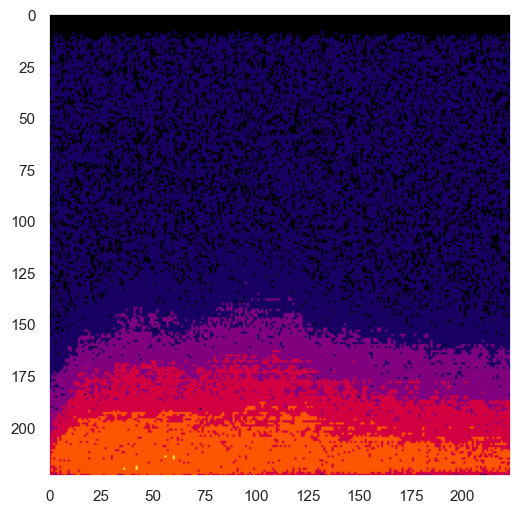

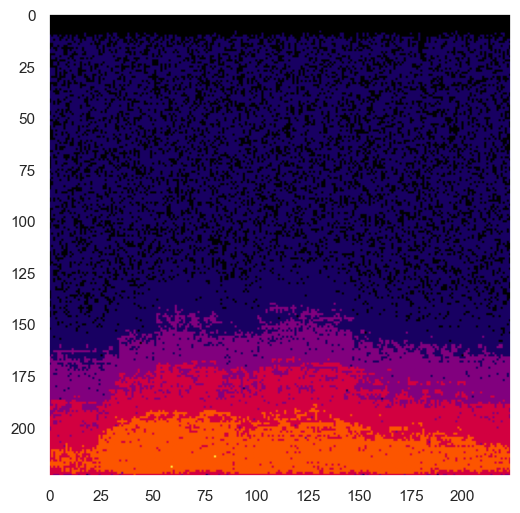

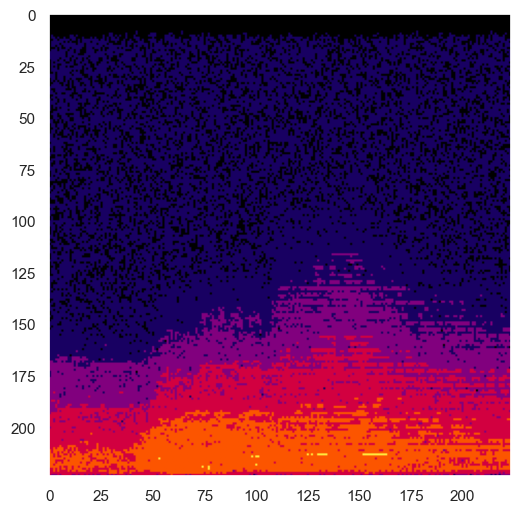

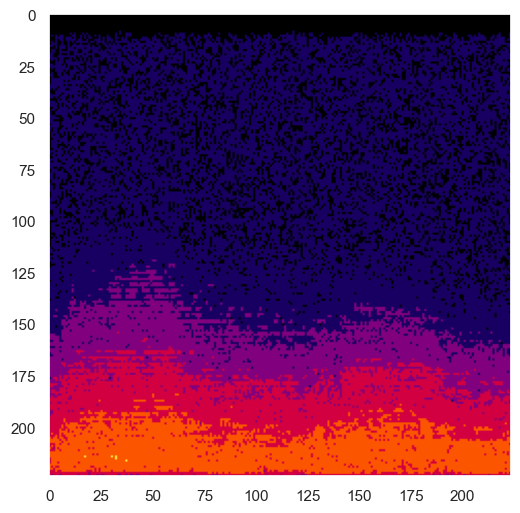

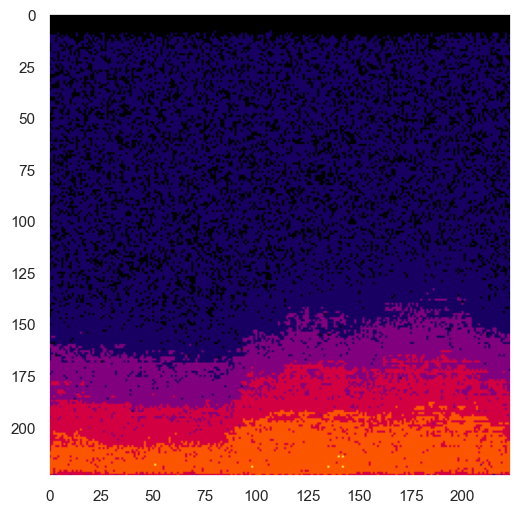

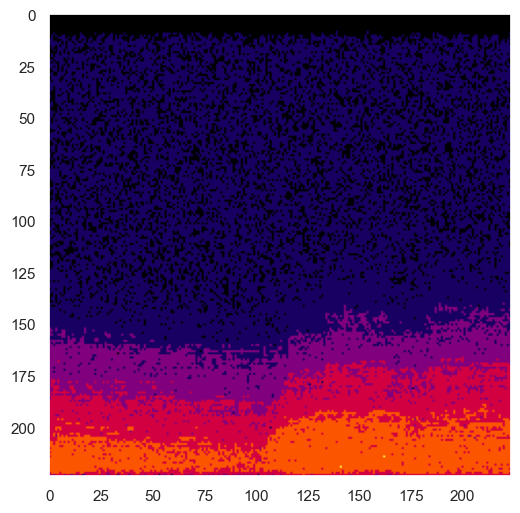

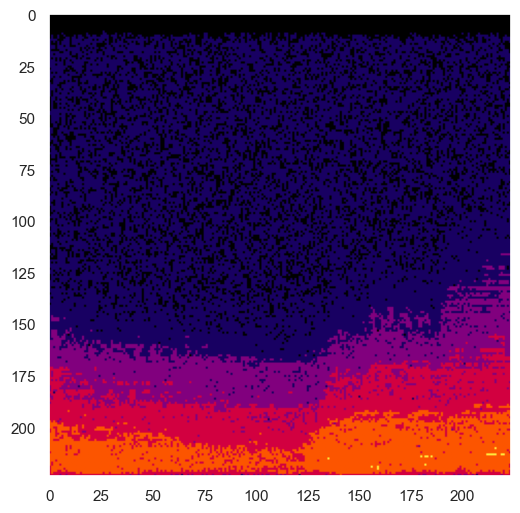

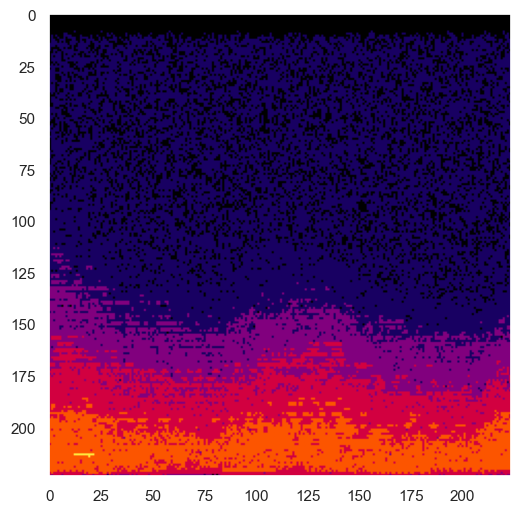

In [38]:
# Once the above is done, plot the spectrograms.

for i in range(8):
    img = mpimg.imread(f"{folder_path}/trumpet{i}_spectrogram.png")
    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.grid()

# 5. Cleanup

Let's remove the donwloaded files and SoX so that we don't crowd up our system if not needed anymore.

> Note: Some of these are needed for the next parts notebooks, so only do this if you are done with the entire series.

In [ ]:
# # Remove the Edge-AI-Upload.zip and file

# folder_names = ["Audio", "Audio-Training", "Dataset", "Images", "Model-Files", "Edge-AI-Upload.zip"]

# for folder in folder_names:
#     if os.path.isfile(folder):
#         os.remove(folder)
#     elif os.path.isdir(folder):
#         shutil.rmtree(folder)

In [ ]:
# # Uninstall SoX
# !brew uninstall sox -q